# Part 2 - Generalization Across Subjects

### 1. Apply the Preprocessing Pipeline to the Data of all Subjects

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import convolve1d
import seaborn as sns
import os
import sys
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# Set root directory
root = Path(os.getcwd()).resolve().parent
if str(root).endswith('nssp-mp2'):
    os.chdir(root)
    sys.path.append(str(root))

# Feature extraction functions
mav = lambda x: np.mean(np.abs(x), axis=0)
std = lambda x: np.std(x, axis=0) 
maxav = lambda x: np.max(np.abs(x), axis=0)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
ssc = lambda x: np.sum(
    ((x[1:-1] - x[:-2]) * (x[1:-1] - x[2:]) >= 0).astype(int),
    axis=0
)

def build_dataset_from_ninapro(emg, stimulus, repetition, features=None, window_len=400, step_len=20):
    """
    Builds a dataset using sliding windows.
    window_len: 400 samples (200ms at 2kHz)
    step_len: 20 samples (10ms at 2kHz) -> High overlap for more data
    """
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    
    dataset_list = []
    labels_list = []
    reps_list = []

    n_channels = emg.shape[1]

    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Select data for this specific stimulus and repetition
            mask = np.logical_and(stimulus == i+1, repetition == j+1).squeeze()
            emg_segment = emg[mask, :]
            
            # Apply sliding window
            n_segment_samples = emg_segment.shape[0]
            if n_segment_samples < window_len:
                continue
                
            for start in range(0, n_segment_samples - window_len + 1, step_len):
                end = start + window_len
                window_data = emg_segment[start:end, :]
                
                # Extract features for this window
                window_features = []
                for feature in features:
                    feat_val = feature(window_data)
                    # Log-transform features to improve normality
                    window_features.append(np.log1p(feat_val))
                
                dataset_list.append(np.concatenate(window_features))
                labels_list.append(i+1)
                reps_list.append(j+1)

    if not dataset_list:
        return np.array([]), np.array([]), np.array([])

    return np.array(dataset_list), np.array(labels_list), np.array(reps_list)

def load_all_subjects(data_dir, features):
    """
    Iterates through the data directory and loads data for all subjects.
    Returns a dictionary where keys are subject IDs (e.g., 's1') and values are (dataset, labels, reps).
    Applies Per-Subject Standardization.
    """
    subjects_data = {}
    
    if not os.path.exists(data_dir):
        print(f"Data directory {data_dir} not found.")
        return {}

    subject_dirs = [d for d in os.listdir(data_dir) if d.startswith('s') and os.path.isdir(os.path.join(data_dir, d))]
    subject_dirs.sort()

    print(f"Found {len(subject_dirs)} subjects.")

    for subject_dir in subject_dirs:
        subject_id = subject_dir
        subject_path = os.path.join(data_dir, subject_dir)
        
        files = os.listdir(subject_path)
        e1_files = [f for f in files if 'E1' in f and f.endswith('.mat')]
        
        if not e1_files:
            continue
            
        file_path = os.path.join(subject_path, e1_files[0])
        
        try:
            data = loadmat(file_path)
            emg = data['emg']
            stimulus = data['stimulus']
            repetition = data['repetition']
            
            dataset, labels, reps = build_dataset_from_ninapro(emg, stimulus, repetition, features, window_len=400, step_len=20)
            
            if dataset.size > 0:
                # Per-subject standardization (Domain Adaptation)
                scaler = StandardScaler()
                dataset = scaler.fit_transform(dataset)
                subjects_data[subject_id] = (dataset, labels, reps)
            
        except Exception as e:
            print(f"Error loading {subject_id}: {e}")

    return subjects_data

# Define features list
feature_list = [mav, std, maxav, rms, wl, ssc]

### 2. Extract the same set of features and compare them

Found 27 subjects.
Successfully loaded data for 27 subjects.


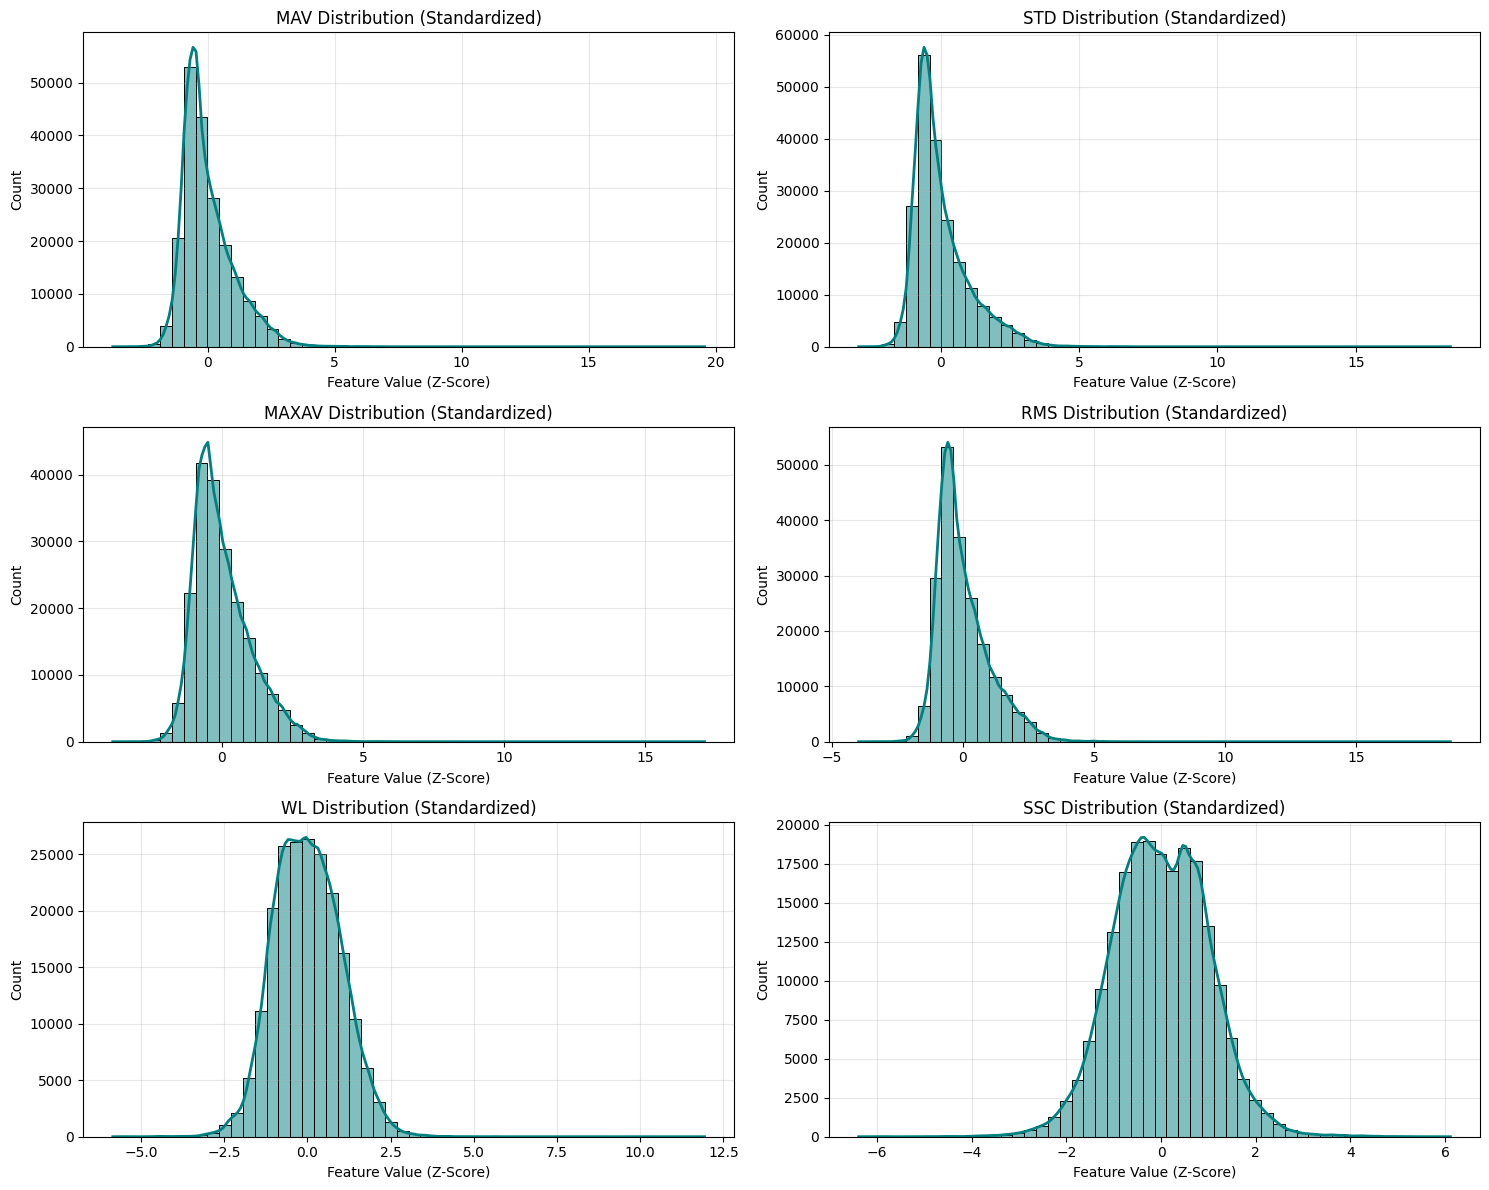

In [2]:
# Load data for all subjects
data_dir = 'data'
all_subjects_data = load_all_subjects(data_dir, feature_list)

print(f"Successfully loaded data for {len(all_subjects_data)} subjects.")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure all_subjects_data is loaded
if all_subjects_data:
    # X_all shape will be (Total_Samples, Total_Columns)
    X_list = []
    subject_ids = []
    for sub_id in sorted(all_subjects_data.keys()):
        X, _, _ = all_subjects_data[sub_id]
        subject_ids.append(sub_id)
        X_list.append(X)
    
    if X_list:
        X_all = np.vstack(X_list)

        n_samples = X_all.shape[0]
        n_features = len(feature_list)
        n_channels = X_all.shape[1] // n_features
        
        # Reshape to (Samples, Features, Channels)
        X_reshaped = X_all.reshape(n_samples, n_features, n_channels)
        
        feature_names = ['MAV', 'STD', 'MAXAV', 'RMS', 'WL', 'SSC']
        
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        axes = axes.flatten()
        
        for i, feature_name in enumerate(feature_names):
            feat_values = X_reshaped[:, i, :].flatten()

            sns.histplot(feat_values, kde=True, ax=axes[i], color='teal', bins=50, line_kws={'linewidth': 2})
            
            axes[i].set_title(f'{feature_name} Distribution (Standardized)', fontsize=12)
            axes[i].set_xlabel('Feature Value (Z-Score)')
            axes[i].set_ylabel('Count')
            axes[i].grid(True, alpha=0.3)
            
        plt.tight_layout()
        plt.show()
    else:
        raise ValueError("all_subjects_data contained empty arrays.")
else:
    raise ValueError("all_subjects_data is empty or not loaded properly.")

### 3. Train a classification model on 26 subjects and evaluate on the 27th subject

In [3]:
def get_data_split(
        subjects_data: dict,
        test_subject_ids: list
    ) -> tuple:
    """
    Splits the data into training (all subjects except test_subject_ids)
    and testing (only test_subject_ids).
    """
    X_train_list, y_train_list = [], []
    X_test_list, y_test_list = [], []

    for sub_id, (X, y, _) in subjects_data.items():
        if sub_id in test_subject_ids:
            X_test_list.append(X)
            y_test_list.append(y)
        else:
            X_train_list.append(X)
            y_train_list.append(y)
        
    if X_train_list:
        X_train = np.vstack(X_train_list)
        y_train = np.concatenate(y_train_list)
    else:
        raise ValueError("No training data available.")
    
    if X_test_list:
        X_test = np.vstack(X_test_list)
        y_test = np.concatenate(y_test_list)
    else:
        raise ValueError("No testing data available.")
    
    # Shuffle training data
    train_indices = np.arange(X_train.shape[0])
    np.random.shuffle(train_indices)
    X_train = X_train[train_indices]
    y_train = y_train[train_indices]
    
    return X_train, y_train, X_test, y_test

In [4]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Example usage on one subject
if subject_ids:
    test_subject = subject_ids[-1]
    print(f"Training model on 26 subjects, testing on {test_subject}...")

    X_train, y_train, X_test, y_test = get_data_split(all_subjects_data, [test_subject])
    print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

    # Ensemble Model
    svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='scale', probability=True))
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    mlp = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
    
    model = VotingClassifier(estimators=[('svm', svm), ('rf', rf), ('mlp', mlp)], voting='soft')
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy on {test_subject}: {accuracy:.4f}")

Training model on 26 subjects, testing on s9...
Train size: 19561, Test size: 732
Accuracy on s9: 0.3333


### 4. Cross Validation: Repeat **Part 3** for each subject

Starting Cross-Validation leaving one subject out every time...

Average Accuracy: 0.4691 (STD: 0.1261)


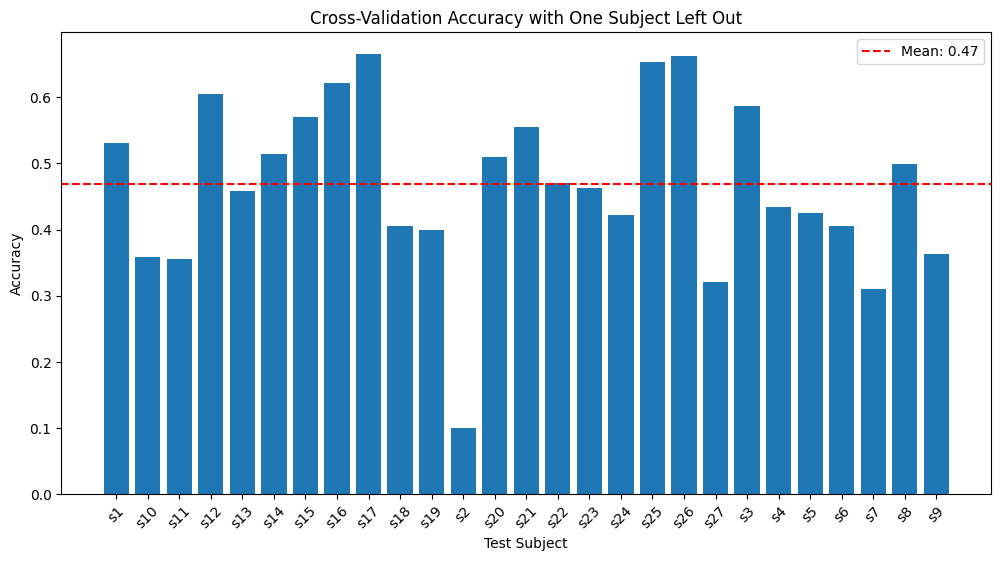

In [5]:
accuracies = []

print("Starting Cross-Validation leaving one subject out every time...")

if subject_ids:
    for subject_id in subject_ids:

        # Use usual data split function
        X_train, y_train, X_test, y_test = get_data_split(all_subjects_data, [subject_id])
        
        # Use SVM for speed in full loop, or Ensemble if preferred
        svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='scale', probability=True))
        rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
        mlp = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
        model = VotingClassifier(estimators=[('svm', svm), ('rf', rf), ('mlp', mlp)], voting='soft')

        # Fit model
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)

    print(f"\nAverage Accuracy: {mean_acc:.4f} (STD: {std_acc:.4f})")

    plt.figure(figsize=(12, 6))
    plt.bar(subject_ids, accuracies)
    plt.axhline(mean_acc, color='r', linestyle='--', label=f'Mean: {mean_acc:.2f}')
    plt.xlabel('Test Subject')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Accuracy with One Subject Left Out')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

### 5. Experiment with different numbers of subjects in the **Test Set**

Test subjects: ['s20', 's12', 's21', 's11', 's26']
Training with 1 subjects...
Training with 3 subjects...
Training with 5 subjects...
Training with 10 subjects...
Training with 15 subjects...
Training with 22 subjects...


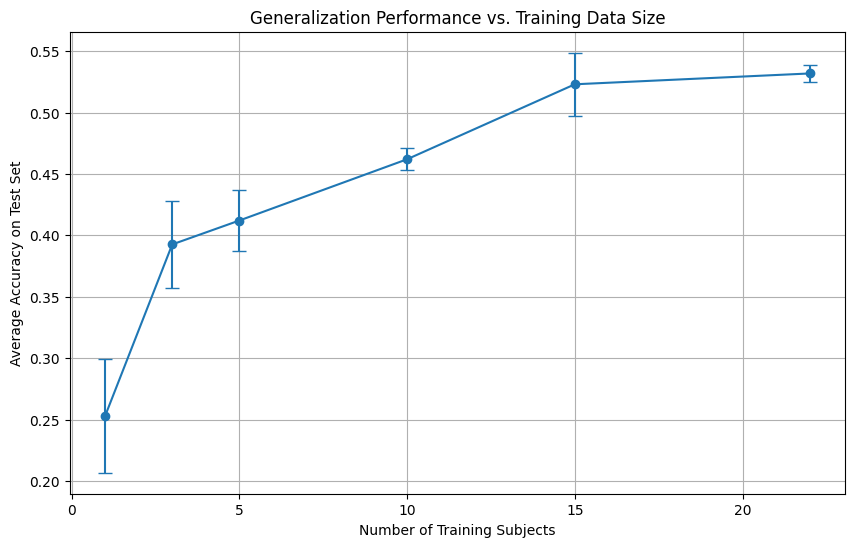

In [8]:
# Experiment: Varying Training Set Size

if len(subject_ids) > 5:
    test_subjects = np.random.choice(subject_ids, size=5, replace=False)
    train_pool_subjects = [s for s in subject_ids if s not in test_subjects]
    test_subjects_subset = test_subjects.tolist()

    training_sizes = [1, 3, 5, 10, 15, len(train_pool_subjects)]
    training_sizes = [s for s in training_sizes if s <= len(train_pool_subjects)]
    training_sizes = sorted(list(set(training_sizes)))
    
    n_repetitions = 5
    results_mean = []
    results_std = []

    X_test, y_test = [], []
    for sub_id in test_subjects_subset:
        X_sub, y_sub, _ = all_subjects_data[sub_id]
        X_test.append(X_sub)
        y_test.append(y_sub)

    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    print(f"Test subjects: {test_subjects_subset}")

    for size in training_sizes:
        print(f"Training with {size} subjects...")
        size_accuracies = []
        
        for _ in range(n_repetitions):
            selected_train_subjects = np.random.choice(train_pool_subjects, size, replace=False)

            X_train, y_train = [], []
            for sub_id in selected_train_subjects:
                X_sub, y_sub, _ = all_subjects_data[sub_id]
                X_train.append(X_sub)
                y_train.append(y_sub)

            X_train = np.vstack(X_train)
            y_train = np.concatenate(y_train)

            # Shuffle training data
            train_indices = np.arange(X_train.shape[0])
            np.random.shuffle(train_indices)
            X_train = X_train[train_indices]
            y_train = y_train[train_indices]

            # Create ensemble model
            svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='scale', probability=True))
            rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
            mlp = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
            model = VotingClassifier(estimators=[('svm', svm), ('rf', rf), ('mlp', mlp)], voting='soft')

            # Fit the model
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            size_accuracies.append(acc)
            
        results_mean.append(np.mean(size_accuracies))
        results_std.append(np.std(size_accuracies))

    plt.figure(figsize=(10, 6))
    plt.errorbar(training_sizes, results_mean, yerr=results_std, fmt='-o', capsize=5)
    plt.xlabel("Number of Training Subjects")
    plt.ylabel("Average Accuracy on Test Set")
    plt.title("Generalization Performance vs. Training Data Size")
    plt.grid(True)
    plt.show()